In [52]:
import pybaseball as pyb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

# Clayton Kershaw Analysis

In [2]:
# 클레이튼 커쇼 정보
pyb.playerid_lookup('kershaw', 'clayton')

Gathering player lookup table. This may take a moment.


,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,kershaw,clayton,477132,kersc001,kershcl01,2036,2008.0,2021.0


In [3]:
# 커쇼의 2008시즌부터 2021시즌까지의 투구 데이터
kershaw = pyb.statcast_pitcher('2008-01-01', '2022-01-01', 477132)

Gathering Player Data


## Pitch Selection by Year

In [4]:
# Data Cleaning
kershaw['year'] = kershaw['game_date'].str[:4]
kershaw_stats = kershaw.loc[~kershaw['pitch_type'].isna()]

In [5]:
# 시즌별, 구종별 데이터 합산
kershaw_seasons = kershaw_stats.groupby(['year', 'pitch_name']).agg({
    'player_name': 'size',
    'release_speed': 'mean',
    'release_spin_rate': 'mean',
    'pfx_x': 'mean',
    'pfx_z': 'mean',
    'spin_axis': 'mean'
}).reset_index()

In [6]:
# 시즌별 총 투구수 계산
pitch_count = kershaw_seasons.groupby('year')['player_name'].sum().reset_index().rename(columns={'player_name': 'total_count'})
kershaw_seasons = kershaw_seasons.merge(pitch_count, on='year')
kershaw_seasons.rename(columns={'player_name': 'count'}, inplace=True)

In [7]:
# 구종별 Percentage 계산
kershaw_seasons['percentage'] = kershaw_seasons['count']/kershaw_seasons['total_count']

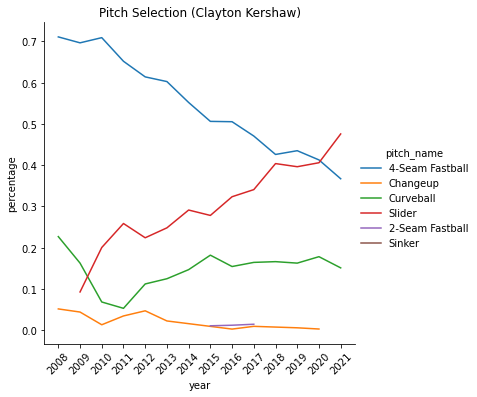

In [65]:
# 시각화
ax = sns.relplot(data=kershaw_seasons, x='year', y='percentage', kind='line', hue='pitch_name')
ax.set_xticklabels(rotation=45)
ax.set(title='Pitch Selection (Clayton Kershaw)')
plt.show()

커쇼의 투구 구종 비율을 연도별 라인 그래프로 표현하였다. 포심 패스트볼과 **슬라이더**의 구사 비율이 가장 눈에 띄는 것을 확인할 수 있다. 커쇼는 2008년 메이저리그에 처음 등판하였을 때, 70% 이상 포심패스트볼을 던졌고 슬라이더는 던지지 않았다. 그러나 시즌이 거듭될수록 포심의 비중은 점점 줄어드는 반면에, 슬라이더의 비중을 높여 2021년에는 포심보다 슬라이더를 더 많이 던졌다. 

## Swing & Miss by Pitch Type

In [9]:
# 헛스윙 (swinging_strike)
strikes = kershaw_stats[kershaw_stats['description']=='swinging_strike']
strikes = strikes.groupby(['year', 'pitch_name']).count().reset_index().loc[:,['year', 'pitch_name', 'pitch_type']]

In [10]:
# 총 투구 수 중 헛스윙 비율 계산
total_pitch = kershaw_seasons.loc[:,['year', 'pitch_name', 'count']]
strikes = strikes.merge(total_pitch, on=['year', 'pitch_name'])
strikes['swing_miss_percent'] = strikes['pitch_type']/strikes['count']

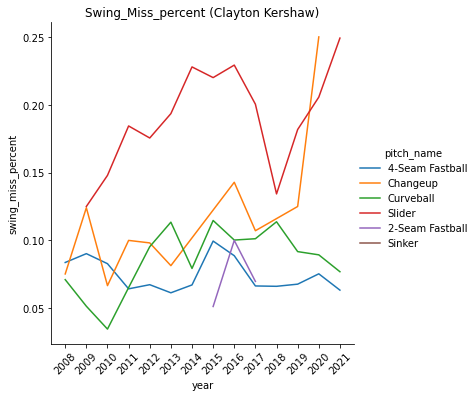

In [11]:
# 시각화
ax = sns.relplot(data=strikes, x='year', y='swing_miss_percent', kind='line', hue='pitch_name')
ax.set_xticklabels(rotation=45)
ax.set(title='Swing_Miss_percent (Clayton Kershaw)')
plt.show()

구종별 헛스윙 비율(swinging_strike / total_pitch)을 그래프로 표현하였다. 포심의 경우 헛스윙 비율이 10%에도 못미치는 반면에 **슬라이더**는 헛스윙 비율이 2018 시즌을 제외하면 꾸준히 증가해서 25%까지 상승하는 것을 볼 수 있다.   
커쇼가 처음 사이영상을 수상한 2011년에는 전년보다 **슬라이더**의 헛스윙비율이 무려 5% 포인트 가량 증가하였고, 꾸준히 증가하는 **슬라이더**의 헛스윙 비율에 따라 커쇼가 구사한 **슬라이더**의 비중도 높아진 것으로 판단된다.

## Kershaw's Slider

### 1. Velocity

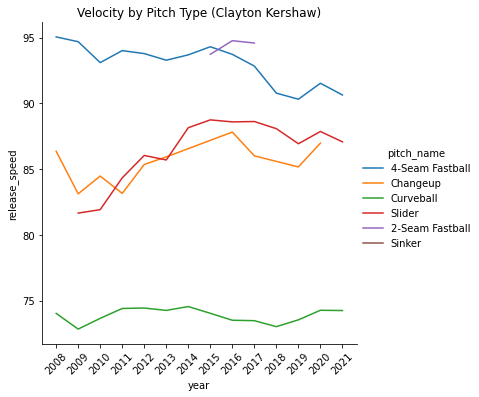

In [24]:
# 시즌별 구종별 구속의 변화 시각화
ax = sns.relplot(data=kershaw_seasons, x='year', y='release_speed', kind='line', hue='pitch_name')
ax.set_xticklabels(rotation=45)
ax.set(title='Velocity by Pitch Type (Clayton Kershaw)')
plt.show()

커쇼의 구종별 구속을 시각화하였다. 2009년 처음 슬라이더를 던졌을 때 평균 80대 초반의 구속을 보였지만, 시즌이 거듭될수록 슬라이더의 구속이 꾸준히 상승하여 평균 80대 후반의 구속을 나타내었다.   
구속의 증가에 따라 헛스윙 비율이 늘어나고, 이에 따라 슬라이더의 구사 비율을 점점 늘려간 것으로 보인다. 커쇼의 슬라이더의 구속과 헛스윙의 상관관계가 있는지 분석해보았다.

In [13]:
sm_percent = strikes[['year','pitch_name','swing_miss_percent']]
kershaw_seasons = kershaw_seasons.merge(sm_percent, on=['year','pitch_name'])

In [14]:
# 슬라이더 데이터만 추출
slider = kershaw_seasons[kershaw_seasons['pitch_name']=='Slider']

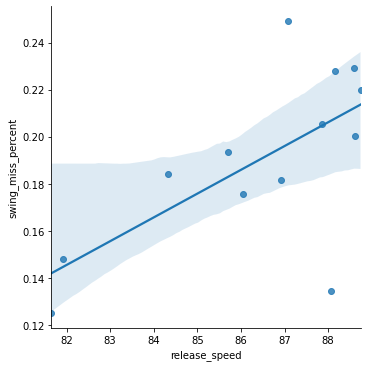

In [15]:
# 구속과 헛스윙율의 관계성을 파악하기 위한 시각화
sns.lmplot(x='release_speed', y='swing_miss_percent', data=slider)
plt.show()

In [16]:
# 선형 회귀 분석
import statsmodels.formula.api as smf
reg_1 = smf.ols(formula = 'swing_miss_percent ~ release_speed', data=slider).fit()
reg_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     swing_miss_percent   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.373
Method:                 Least Squares   F-statistic:                     8.144
Date:                Sun, 09 Jan 2022   Prob (F-statistic):             0.0157
Time:                        09:46:46   Log-Likelihood:                 28.258
No. Observations:                  13   AIC:                            -52.52
Df Residuals:                      11   BIC:                            -51.39
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.6829      0.306     -2.231      0.047      -1.357      -0.009
release_speed     0.0101      0.004      2.854      0.016       0.002       0.018
==============================================================================
Omnibus:                        7.044   Durbin-Watson:                   1.316
Prob(Omnibus):                  0.030   Jarque-Bera (JB):                3.333
Skew:                          -0.854   Prob(JB):                        0.189
Kurtosis:                       4.798   Cond. No.                     3.19e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.19e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

회귀 분석을 통해 슬라이더의 구속이 늘어날수록 헛스윙율 또한 상승하는 것을 확인할 수 있었다. 
   
구속 뿐만 아니라 공의 특성을 확인할 수 있는 지표는 spin_rate이다. 커쇼의 시즌별 투구 회전 수에 어떤 변화가 있었는지 확인해보았다. 
   


### 2. 회전 수

구속뿐만 아니라, 공의 특성을 설명하기 위해서는 회전 수와 회전 방향, 회전 효율 등의 공의 회전과 관련된 데이터를 살펴보고 분석해야 한다. Statcast가 제공하는 데이터에서 회전 수와 회전 방향에 대한 데이터는 확인할 수 있지만, 회전 효율에 대한 데이터를 확인할 수 없었다. 슬라이더의 경우 패스트볼이나 커브에 비해 회전 효율이 낮은 구종이기 때문에, 회전 수 데이터만 가지고 슬라이더의 특성을 설명하기 어려웠다.   
   
게다가 회전 수가 측정된 시기가 2015년부터이기 때문에 데이터의 양이 충분하지 않았지만, 15년 이후에 측정된 데이터로도 변화를 확인할 수 있었다.

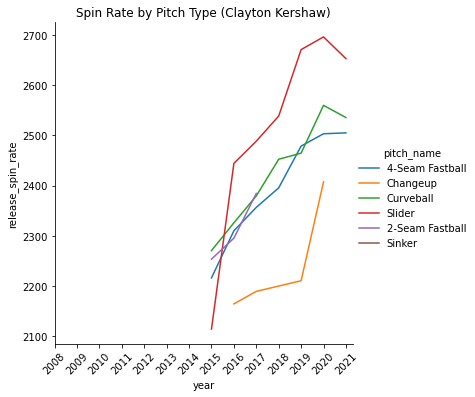

In [63]:
ax = sns.relplot(data=kershaw_seasons, x='year', y='release_spin_rate', kind='line', hue='pitch_name')
ax.set_xticklabels(rotation=45)
ax.set(title='Spin Rate by Pitch Type (Clayton Kershaw)')
plt.show()

커쇼의 모든 구종의 회전수가 증가하는 경향을 보였지만, 특히 슬라이더의 회전수가 크게 증가하였다. 